--- Starting Model Training ---
✓ AAPL: 3772 data points downloaded.
✓ GOOGL: 3772 data points downloaded.
✓ MSFT: 3772 data points downloaded.
✓ TSLA: 3772 data points downloaded.
✓ AMZN: 3772 data points downloaded.
✓ NVDA: 3772 data points downloaded.
✓ META: 3317 data points downloaded.
✓ NFLX: 3772 data points downloaded.
✓ JPM: 3772 data points downloaded.
✓ V: 3772 data points downloaded.
Fitting scaler on combined data...
Scaler fitted successfully.
Total data shape: torch.Size([37015, 20, 22])
Starting training: epochs=50, lr=0.0005, batch_size=128
Epoch 01 | Train Loss: 1.0796, Acc: 39.68% | Val Loss: 1.0355, Acc: 51.57% -> Val loss improved, model saved.
Epoch 02 | Train Loss: 1.0751, Acc: 40.01% | Val Loss: 1.0173, Acc: 52.02% -> Val loss improved, model saved.
Epoch 03 | Train Loss: 1.0753, Acc: 39.93% | Val Loss: 1.0205, Acc: 50.66% -> No improvement (1/7)
Epoch 04 | Train Loss: 1.0732, Acc: 40.88% | Val Loss: 1.0224, Acc: 52.29% -> No improvement (2/7)
Epoch 05 | Train L

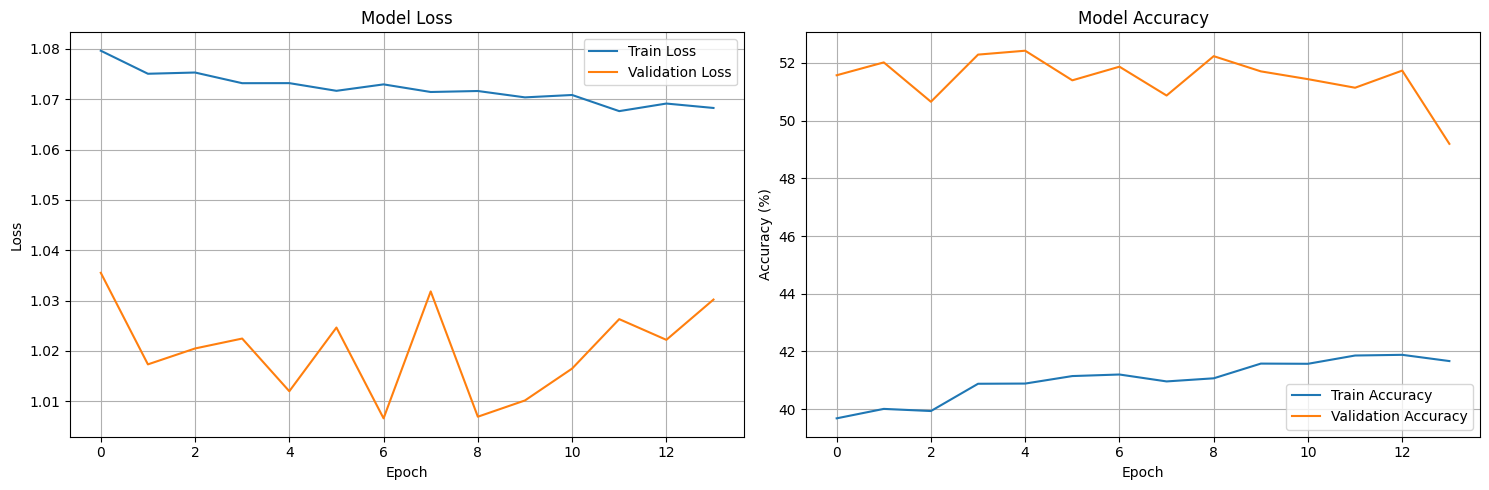


--- Analyzing SPY with Trained Model ---
✓ SPY: 1255 data points downloaded.
✓ SPY: 158 data points downloaded.

ML-ENHANCED TRADING ANALYSIS: SPY
  FINAL SIGNAL:             BUY
  FINAL CONFIDENCE:         72.0%
----------------------------------------------------------------------
  --- ML Model Analysis ---
  ML Signal:                SELL
  ML Confidence:            50.0%

  --- Traditional Analysis ---
  Traditional Signal:       BUY
  Signals Agreement:        False
  Current Price:            $635.26
  Nearest S/R Level:        $560.14 (11.8% away)
  Stochastic %K:            83.46
  Volatility Expansion:     -56.37%
  Trend (20D/40D/200D):     up/up/up
  MACD Hist Momentum:       Falling


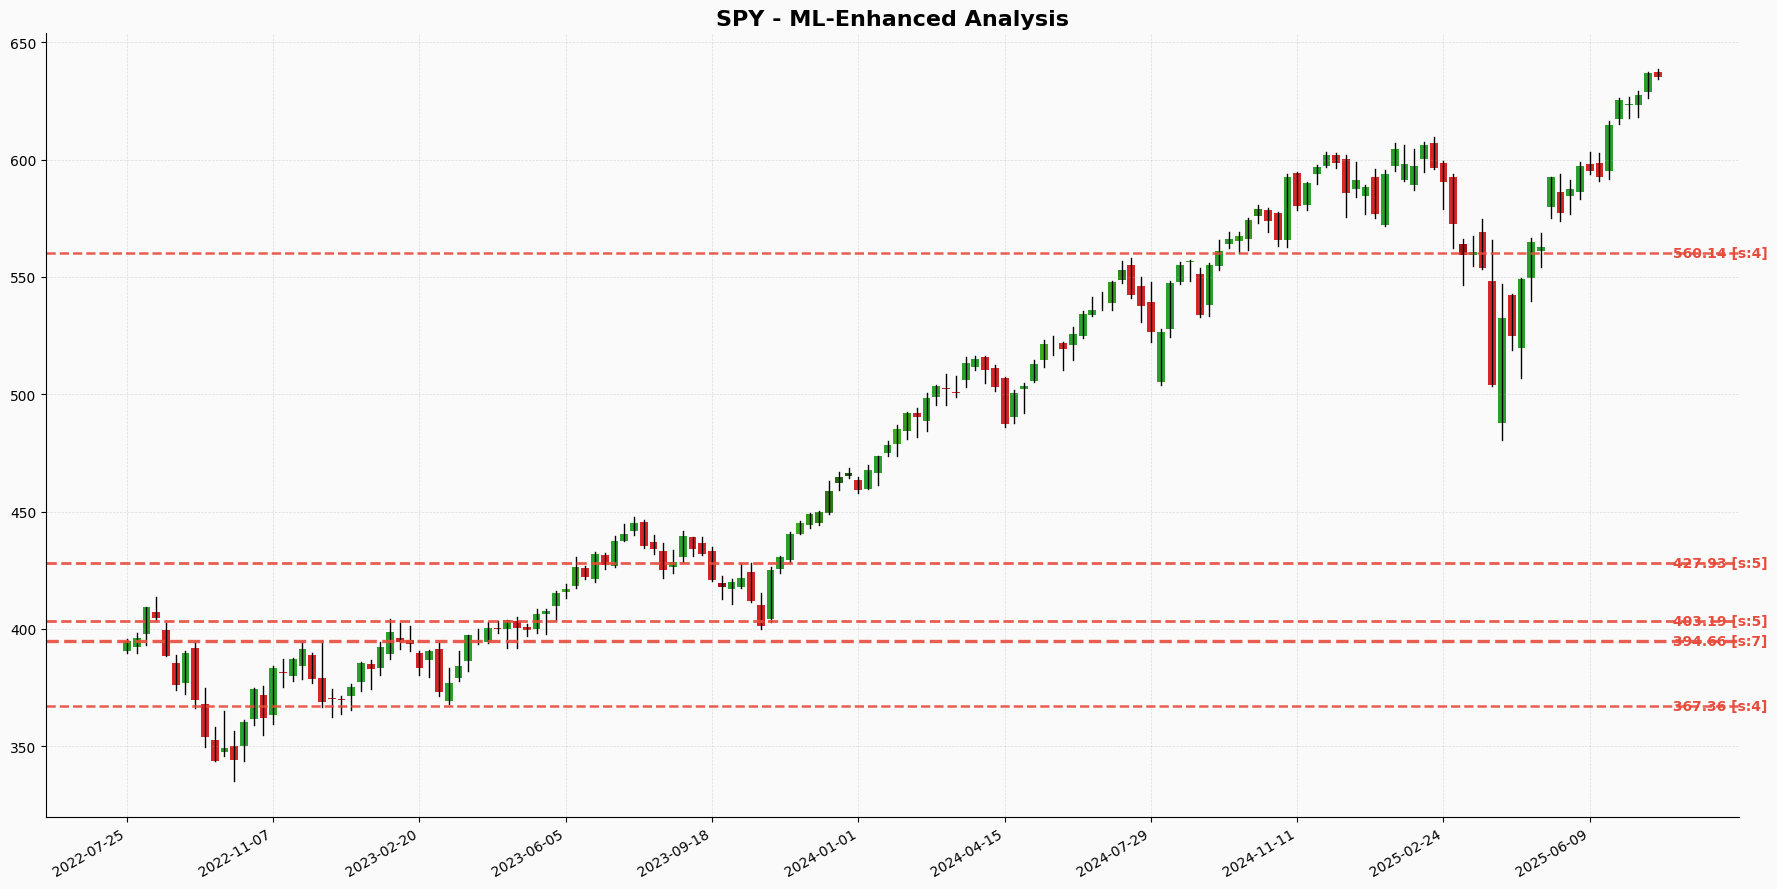

In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import warnings
import os

warnings.filterwarnings('ignore')

# --- 1. NEURAL NETWORK DEFINITION (Input size updated) ---
class TradingSignalNet(nn.Module):
    """LSTM and Attention network with strong regularization."""
    # ENHANCEMENT: Increased input_size from 17 to 22 to include new features
    def __init__(self, input_size=22, hidden_size=96, num_layers=1, dropout=0.4):
        super(TradingSignalNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0)
        self.attention = nn.MultiheadAttention(hidden_size, 8, batch_first=True, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 48), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(48, 24), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(24, 3)
        )
        self.confidence = nn.Sequential(
            nn.Linear(hidden_size, 24), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(24, 1), nn.Sigmoid()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attended, _ = self.attention(lstm_out, lstm_out, lstm_out)
        final_hidden = attended[:, -1, :]
        return self.classifier(final_hidden), self.confidence(final_hidden)

# --- 2. DATASET PREPARATION (Feature list updated) ---
class TradingDataset:
    """Handles data preparation, feature engineering, and sequence creation."""
    def __init__(self, sequence_length=20):
        self.sequence_length = sequence_length
        self.scaler = StandardScaler()
        self.is_scaler_fitted = False
        # ENHANCEMENT: Added Stochastics and MA Slopes to the feature list
        self.feature_cols = [
            'Close', 'Volume', 'macd', 'signal', 'hist', 'rsi', 'bb_upper',
            'bb_lower', 'atr', 'volatility', 'volume_ratio', 'price_change',
            'high_low_ratio', 'close_position', 'pivot_signal', 'roc', 'coppock',
            '%K', '%D', 'slope_20', 'slope_40', 'slope_200'
        ]

    def prepare_training_data(self, df_list):
        print("Fitting scaler on combined data...")
        all_dfs = [EnhancedAdaptiveTradingSystem.add_all_indicators(df.copy()) for df in df_list]
        combined = pd.concat(all_dfs)
        combined[self.feature_cols] = combined[self.feature_cols].ffill().fillna(0)
        self.scaler.fit(combined[self.feature_cols].values)
        self.is_scaler_fitted = True
        print("Scaler fitted successfully.")

        all_sequences, all_labels = [], []
        for df in all_dfs:
            sequences, labels = self.create_sequences_with_labels(df)
            if sequences:
                all_sequences.extend(sequences)
                all_labels.extend(labels)
        if not all_sequences:
            return None, None, None

        X = torch.FloatTensor(np.array(all_sequences))
        y = torch.LongTensor(np.array(all_labels))
        print(f"Total data shape: {X.shape}")
        return X, y, all_labels

    def create_sequences_with_labels(self, df):
        if not self.is_scaler_fitted: raise RuntimeError("Scaler not fitted.")
        df[self.feature_cols] = df[self.feature_cols].ffill().fillna(0)
        df['future_return'] = df['Close'].shift(-5) / df['Close'] - 1
        df['label'] = 1; df.loc[df['future_return'] > 0.02, 'label'] = 0; df.loc[df['future_return'] < -0.02, 'label'] = 2
        if len(df) < self.sequence_length + 5: return [], []

        scaled_features = self.scaler.transform(df[self.feature_cols].values)
        sequences, labels = [], []
        for i in range(self.sequence_length, len(scaled_features) - 5):
            if not np.isnan(df['label'].iloc[i]):
                sequences.append(scaled_features[i - self.sequence_length:i])
                labels.append(int(df['label'].iloc[i]))
        return sequences, labels

# --- 3. MODEL TRAINING ---
class TradingModelTrainer:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device); self.device = device
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def train_model(self, X_train, y_train, y_train_labels_for_sampler, X_val, y_val, epochs, batch_size, lr):
        class_counts = np.bincount(y_train_labels_for_sampler); class_weights = 1.0 / class_counts
        samples_weight = np.array([class_weights[t] for t in y_train_labels_for_sampler])
        sampler = WeightedRandomSampler(torch.from_numpy(samples_weight), len(samples_weight))
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4); criterion = nn.CrossEntropyLoss()
        best_val_loss = float('inf'); patience = 7; epochs_no_improve = 0

        print(f"Starting training: epochs={epochs}, lr={lr}, batch_size={batch_size}")
        for epoch in range(epochs):
            self.model.train()
            for data, target in train_loader:
                data, target = data.to(self.device), target.to(self.device); optimizer.zero_grad()
                signal_output, _ = self.model(data); loss = criterion(signal_output, target)
                loss.backward(); optimizer.step()

            avg_train_loss, train_acc = self.evaluate_epoch(train_loader)
            avg_val_loss, val_acc = self.evaluate_epoch(val_loader)
            self.history['train_loss'].append(avg_train_loss); self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(avg_val_loss); self.history['val_acc'].append(val_acc)
            print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%", end="")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss; torch.save(self.model.state_dict(), 'best_trading_model.pth')
                epochs_no_improve = 0; print(" -> Val loss improved, model saved.")
            else:
                epochs_no_improve += 1; print(f" -> No improvement ({epochs_no_improve}/{patience})")

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered."); break

        print("\nTraining finished. Loading best model state.")
        self.model.load_state_dict(torch.load('best_trading_model.pth'))

    def evaluate_epoch(self, data_loader):
        self.model.eval(); total_loss, total_correct, total_samples = 0.0, 0, 0
        criterion = nn.CrossEntropyLoss()
        with torch.no_grad():
            for data, target in data_loader:
                data, target = data.to(self.device), target.to(self.device)
                signal_output, _ = self.model(data); loss = criterion(signal_output, target)
                total_loss += loss.item() * data.size(0); _, predicted = torch.max(signal_output.data, 1)
                total_correct += (predicted == target).sum().item(); total_samples += target.size(0)
        return (total_loss / total_samples, 100 * total_correct / total_samples) if total_samples > 0 else (0, 0)

    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(self.history['train_loss'], label='Train Loss'); ax1.plot(self.history['val_loss'], label='Validation Loss')
        ax1.set(title='Model Loss', xlabel='Epoch', ylabel='Loss'); ax1.legend(); ax1.grid(True)
        ax2.plot(self.history['train_acc'], label='Train Accuracy'); ax2.plot(self.history['val_acc'], label='Validation Accuracy')
        ax2.set(title='Model Accuracy', xlabel='Epoch', ylabel='Accuracy (%)'); ax2.legend(); ax2.grid(True)
        plt.tight_layout(); plt.show()

# --- 4. MAIN SYSTEM ORCHESTRATOR ---
class EnhancedAdaptiveTradingSystem:
    def __init__(self, model_path=None):
        self.model = TradingSignalNet()
        self.dataset = TradingDataset()
        self.trainer = TradingModelTrainer(self.model)
        self.is_trained = False
        if model_path and os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path)); self.is_trained = True
            print(f"Loaded pre-trained model from {model_path}")

    def train_on_multiple_stocks(self, tickers, epochs, train_split, lr, batch_size):
        print(f"Collecting data...")
        df_list = [self.get_stock_data(ticker) for ticker in tickers]
        df_list = [df for df in df_list if df is not None]
        if len(df_list) < 2: print("Not enough valid data for training!"); return
        X, y, all_labels = self.dataset.prepare_training_data(df_list)
        if X is None: print("Sequence generation failed!"); return
        split_idx = int(len(X) * train_split)
        X_train, X_val = X[:split_idx], X[split_idx:]; y_train, y_val = y[:split_idx], y[split_idx:]
        y_train_labels = all_labels[:split_idx]
        self.trainer.train_model(X_train, y_train, y_train_labels, X_val, y_val, epochs, batch_size, lr)
        self.is_trained = True; self.trainer.plot_training_history()

    def adaptive_dca_indicator(self, ticker, period="3y", interval="1wk"):
        if not self.is_trained:
            if os.path.exists('best_trading_model.pth'):
                print("Loading trained model..."); self.model.load_state_dict(torch.load('best_trading_model.pth')); self.is_trained = True
            else: print("Model has not been trained!"); return (None,) * 7
        df_daily = self.get_stock_data(ticker, period="5y", interval="1d")
        df_weekly = self.get_stock_data(ticker, period=period, interval=interval)
        if df_daily is None or df_weekly is None: return (None,) * 7
        df_weekly_ml = self.add_all_indicators(df_weekly.copy())
        signal, confidence, analysis = self.generate_ml_enhanced_signal(df_weekly_ml, df_daily)
        df_weekly_chart = self.add_all_indicators(df_weekly.copy(), for_charting=True)
        fig, ax = create_adaptive_visualization(df_weekly_chart, analysis['sr_levels'], ticker)
        return df_weekly, analysis['sr_levels'], fig, ax, signal, confidence, analysis

    def generate_ml_enhanced_signal(self, df_for_ml, df_for_traditional):
        if not self.dataset.is_scaler_fitted:
            print("Warning: Scaler not fitted for inference.")
            trad_sig, trad_conf, analysis = self.generate_traditional_signal(df_for_traditional)
            analysis['ml_signal'] = "N/A"; return trad_sig, trad_conf, analysis
        features = self.dataset.feature_cols; df_for_ml[features] = df_for_ml[features].ffill().fillna(0)
        scaled = self.dataset.scaler.transform(df_for_ml[features].values); last_seq = scaled[-self.dataset.sequence_length:]
        tensor = torch.FloatTensor(last_seq).unsqueeze(0)
        self.model.eval()
        with torch.no_grad():
            logits, conf_score = self.model(tensor)
            ml_signal = ['buy', 'hold', 'sell'][torch.argmax(logits, dim=1).item()]; ml_conf = conf_score.item()
        trad_sig, trad_conf, analysis = self.generate_traditional_signal(df_for_traditional)
        analysis.update({'ml_signal': ml_signal, 'ml_confidence': ml_conf, 'traditional_signal': trad_sig})
        if ml_signal == trad_sig:
            final_sig = ml_signal; final_conf = (ml_conf * 0.7) + (trad_conf * 0.3); analysis['signal_agreement'] = True
        else:
            final_sig = ml_signal if ml_conf > trad_conf else trad_sig; final_conf = max(ml_conf, trad_conf) * 0.8; analysis['signal_agreement'] = False
        return final_sig, final_conf, analysis

    def generate_traditional_signal(self, df):
        df_daily = self.add_all_indicators(df.copy()); latest = df_daily.iloc[-1]; price = latest['Close']
        sr_levels = self.calculate_support_resistance(df_daily); nearest, min_dist = (None, 1.0)
        if sr_levels:
            distances = [(abs(price - lvl[0]) / price, lvl) for lvl in sr_levels]
            if distances: min_dist, nearest = min(distances, key=lambda x: x[0])
        vol_means = {w: df_daily['volatility'].rolling(w).mean().iloc[-1] for w in [5, 30, 60, 180, 360]}
        vol_context_score = (vol_means[5] - vol_means[360]) / vol_means[360] if vol_means[360] > 0 else 0
        trend_scores = {p: latest[f'slope_{p}'] for p in [20, 40, 200]}
        buy_score, sell_score = self.calculate_signal_scores(latest, nearest, min_dist, vol_context_score, trend_scores)
        if buy_score > sell_score + 1: signal, conf = "buy", 0.6 + (buy_score / 10)
        elif sell_score > buy_score + 1: signal, conf = "sell", 0.6 + (sell_score / 10)
        else: signal, conf = "hold", 0.5
        analysis = {
            'current_price': price, 'nearest_sr_level': nearest[0] if nearest else "N/A",
            'distance_to_sr_pct': min_dist * 100, 'macd_hist_momentum': 'rising' if latest['hist'] > df_daily['hist'].iloc[-2] else 'falling',
            'stochastic_%K': latest['%K'], 'volatility_expansion': f"{vol_context_score:.2%}",
            'trend_20D': 'up' if trend_scores[20] > 0 else 'down', 'trend_40D': 'up' if trend_scores[40] > 0 else 'down',
            'trend_200D': 'up' if trend_scores[200] > 0 else 'down', 'sr_levels': sr_levels
        }
        return signal, np.clip(conf, 0, 1), analysis

    def calculate_signal_scores(self, latest, nearest, min_dist, vol_context, trend_scores):
        buy_score, sell_score = 0, 0
        if trend_scores[200] > 0 and trend_scores[40] > 0: buy_score += 2
        if trend_scores[200] < 0 and trend_scores[40] < 0: sell_score += 2
        if nearest and min_dist < 0.03:
            if latest['Close'] < nearest[0]: buy_score += 1.5
            else: sell_score += 1.5
        if latest['hist'] > latest['signal'] and latest['hist'] < 0: buy_score += 1
        if latest['hist'] < latest['signal'] and latest['hist'] > 0: sell_score += 1
        if latest['%K'] < 20: buy_score += 1
        if latest['%K'] > 80: sell_score += 1
        if vol_context < -0.25:
            if buy_score > sell_score: buy_score += 1
            if sell_score > buy_score: sell_score += 1
        return buy_score, sell_score

    # --- Static Methods for Calculations & Utilities ---
    @staticmethod
    def get_stock_data(ticker, period="15y", interval="1d"):
        try:
            df = yf.Ticker(ticker).history(period=period, interval=interval)
            if df.empty: print(f"✗ {ticker}: No data found."); return None
            print(f"✓ {ticker}: {len(df)} data points downloaded."); return df
        except Exception as e: print(f"✗ {ticker}: Error downloading data - {e}"); return None

    @staticmethod
    def add_all_indicators(df, for_charting=False):
        df = EnhancedAdaptiveTradingSystem.calculate_wma_macd(df)
        df = EnhancedAdaptiveTradingSystem.calculate_stochastics(df)
        df['rsi'] = (100-(100/(1+(df['Close'].diff().where(df['Close'].diff()>0,0).rolling(14).mean()/-df['Close'].diff().where(df['Close'].diff()<0,0).rolling(14).mean()).fillna(0))))
        sma20 = df['Close'].rolling(20).mean(); std20 = df['Close'].rolling(20).std()
        df['bb_upper'] = sma20+(std20*2); df['bb_lower'] = sma20-(std20*2)
        tr = pd.concat([df['High']-df['Low'], np.abs(df['High']-df['Close'].shift()), np.abs(df['Low']-df['Close'].shift())], axis=1).max(axis=1)
        df['atr'] = tr.rolling(14).mean()
        df['volatility'] = df['Close'].pct_change().rolling(20).std()
        df['roc'] = (df['Close']-df['Close'].shift(14))/df['Close'].shift(14)
        df['coppock'] = EnhancedAdaptiveTradingSystem.calculate_wma_macd(pd.DataFrame({'Close':(df['Close'].pct_change(14)+df['Close'].pct_change(11))*100}))['macd']
        if for_charting:
            df['pivot_value'] = df['High'].rolling(21,center=True).apply(lambda x: x.iloc[10] if x.iloc[10]==x.max() or x.iloc[10]==x.min() else np.nan,raw=False)
            up=df['Close']>df['Close'].shift(1); down=df['Close']<df['Close'].shift(1)
            df['buy_count'] = up.cumsum()-up.cumsum().where(~up).ffill().fillna(0)
            df['sell_count'] = down.cumsum()-down.cumsum().where(~down).ffill().fillna(0)
        df['pivot_signal']=0; df['volume_ratio']=0; df['price_change']=0; df['high_low_ratio']=0; df['close_position']=0
        for p in [20, 40, 200]:
            df[f'sma_{p}'] = df['Close'].rolling(p).mean()
            df[f'slope_{p}'] = df[f'sma_{p}'].rolling(5).apply(lambda x: np.polyfit(range(len(x)),x,1)[0] if not x.isnull().any() else np.nan,raw=False)
        return df

    @staticmethod
    def calculate_wma_macd(df, fast=12, slow=26, signal=9):
        def wma(s, w):
            weights = np.arange(1, w + 1); return s.rolling(w).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
        df['macd'] = wma(df['Close'], fast) - wma(df['Close'], slow)
        df['signal'] = wma(df['macd'], signal); df['hist'] = df['macd'] - df['signal']; return df

    @staticmethod
    def calculate_stochastics(df, k_period=14, d_period=3):
        low_min = df['Low'].rolling(window=k_period).min(); high_max = df['High'].rolling(window=k_period).max()
        df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min); df['%D'] = df['%K'].rolling(window=d_period).mean(); return df

    @staticmethod
    def calculate_support_resistance(df, width_pct=5, max_lvls=5, min_str=2):
        pivots=df['Close'].rolling(21,center=True).apply(lambda x:x.iloc[10] if (x.iloc[10]==x.max() or x.iloc[10]==x.min()) else np.nan,raw=False).dropna().tolist()
        if not pivots: return []
        period_high=df['High'].rolling(252).max().iloc[-1]; period_low=df['Low'].rolling(252).min().iloc[-1]
        rng=(period_high-period_low)*width_pct/100; clusters=[]; pivots=sorted(pivots)
        while pivots:
            seed=pivots.pop(0); cluster=[p for p in pivots if abs(p-seed)<rng]; pivots=[p for p in pivots if p not in cluster]; cluster.append(seed)
            if len(cluster) >= min_str: clusters.append((np.mean(cluster), len(cluster)))
        return sorted(clusters, key=lambda x: x[1], reverse=True)[:max_lvls]

# --- 5. VISUALIZATION and MAIN EXECUTION ---
def create_adaptive_visualization(df, sr_levels, ticker):
    fig, ax = plt.subplots(figsize=(18, 9), facecolor='#fafafa'); ax.set_facecolor('#fafafa')
    b_clrs={4:'#3ea923',5:'#37981f',6:'#31871c',7:'#2b7718',8:'#256615',9:'#1f5511',10:'#19440e'}
    s_clrs={4:'#a71116',5:'#950f13',6:'#820d11',7:'#6f0b0e',8:'#59090c',9:'#4a070a',10:'#380607'}
    for i, (idx, row) in enumerate(df.iterrows()):
        clr='#2ca02c' if row['Close']>=row['Open'] else '#d62728'
        if clr=='#2ca02c' and row['buy_count']>=4: clr=b_clrs.get(int(row['buy_count']),'#19440e')
        if clr=='#d62728' and row['sell_count']>=4: clr=s_clrs.get(int(row['sell_count']),'#380607')
        ax.plot([i,i],[row['Low'],row['High']],color='black',linewidth=1); ax.add_patch(Rectangle((i-0.4,min(row['Open'],row['Close'])),0.8,abs(row['Open']-row['Close']),facecolor=clr))
    price=df['Close'].iloc[-1]
    for level,strength in sr_levels:
        clr='#3498db' if level>price else '#e74c3c'; ax.axhline(y=level,color=clr,linestyle='--',linewidth=1+strength*0.2,alpha=0.9)
        ax.text(len(df),level,f" {level:.2f} [s:{strength}]",color=clr,va='center',fontweight='bold')
    ax.set_title(f'{ticker} - ML-Enhanced Analysis',fontsize=16,fontweight='bold'); step=max(1,len(df)//10)
    ax.set_xticks(range(0,len(df),step)); ax.set_xticklabels([df.index[i].strftime('%Y-%m-%d') for i in range(0,len(df),step)],rotation=30,ha='right')
    ax.grid(True,linestyle='--',linewidth=0.5,alpha=0.4); ax.spines[['top','right']].set_visible(False); plt.tight_layout(); return fig,ax

def run_analysis(ticker, train_first=True, epochs=50):
    system = EnhancedAdaptiveTradingSystem()
    if train_first or not os.path.exists('best_trading_model.pth'):
        training_tickers=['AAPL','GOOGL','MSFT','TSLA','AMZN','NVDA','META','NFLX','JPM','V']
        print("--- Starting Model Training ---")
        system.train_on_multiple_stocks(tickers=training_tickers,epochs=epochs,train_split=0.8,lr=0.0005,batch_size=128)
    print(f"\n--- Analyzing {ticker} with Trained Model ---")
    result = system.adaptive_dca_indicator(ticker)
    if result and result[0] is not None:
        _,_,_,_,signal,confidence,analysis=result
        print(f"\n{'='*70}\nML-ENHANCED TRADING ANALYSIS: {ticker.upper()}\n{'='*70}")
        print(f"  {'FINAL SIGNAL:'.ljust(25)} {signal.upper()}"); print(f"  {'FINAL CONFIDENCE:'.ljust(25)} {confidence*100:.1f}%"); print(f"-"*70)
        print(f"  --- ML Model Analysis ---")
        print(f"  {'ML Signal:'.ljust(25)} {analysis.get('ml_signal','N/A').upper()}"); print(f"  {'ML Confidence:'.ljust(25)} {analysis.get('ml_confidence',0)*100:.1f}%")
        print(f"\n  --- Traditional Analysis ---")
        print(f"  {'Traditional Signal:'.ljust(25)} {analysis.get('traditional_signal','N/A').upper()}"); print(f"  {'Signals Agreement:'.ljust(25)} {analysis.get('signal_agreement',False)}")
        print(f"  {'Current Price:'.ljust(25)} ${analysis['current_price']:.2f}"); print(f"  {'Nearest S/R Level:'.ljust(25)} ${analysis['nearest_sr_level']:.2f} ({analysis['distance_to_sr_pct']:.1f}% away)")
        print(f"  {'Stochastic %K:'.ljust(25)} {analysis['stochastic_%K']:.2f}"); print(f"  {'Volatility Expansion:'.ljust(25)} {analysis['volatility_expansion']}")
        print(f"  {'Trend (20D/40D/200D):'.ljust(25)} {analysis['trend_20D']}/{analysis['trend_40D']}/{analysis['trend_200D']}"); print(f"  {'MACD Hist Momentum:'.ljust(25)} {analysis['macd_hist_momentum'].title()}"); print(f"{'='*70}")
        plt.show()
    else: print("Analysis failed.")

if __name__ == "__main__":
    run_analysis("SPY", train_first=True, epochs=50)

--- Starting Model Training ---
✓ AAPL: 3772 data points downloaded.
✓ GOOGL: 3772 data points downloaded.
✓ MSFT: 3772 data points downloaded.
✓ TSLA: 3772 data points downloaded.
✓ AMZN: 3772 data points downloaded.
✓ NVDA: 3772 data points downloaded.
✓ META: 3317 data points downloaded.
✓ NFLX: 3772 data points downloaded.
✓ JPM: 3772 data points downloaded.
✓ V: 3772 data points downloaded.
Fitting scaler on combined data...
Scaler fitted successfully.
Total data shape: torch.Size([37015, 20, 22])
Starting training: epochs=50, lr=0.0005, batch_size=128
Epoch 01 | Train Loss: 1.0790, Acc: 40.17% | Val Loss: 1.0429, Acc: 51.86% -> Val loss improved, model saved.
Epoch 02 | Train Loss: 1.0754, Acc: 40.49% | Val Loss: 1.0320, Acc: 51.32% -> Val loss improved, model saved.
Epoch 03 | Train Loss: 1.0747, Acc: 40.31% | Val Loss: 1.0249, Acc: 52.82% -> Val loss improved, model saved.
Epoch 04 | Train Loss: 1.0749, Acc: 40.39% | Val Loss: 1.0324, Acc: 50.87% -> No improvement (1/7)
Epoch 0

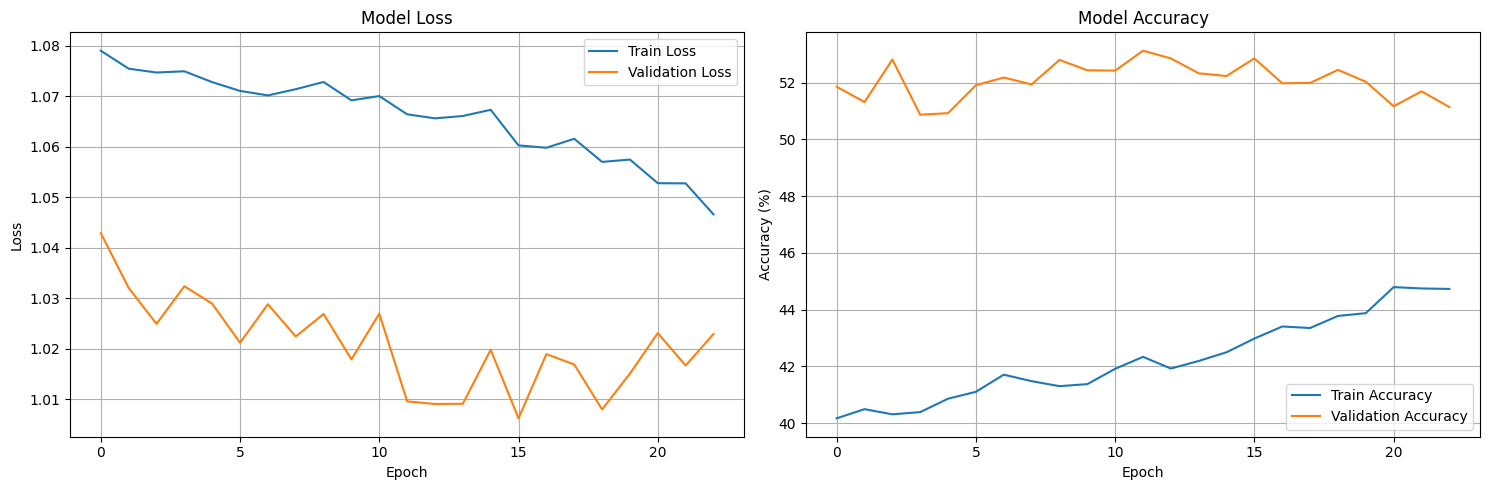


--- Analyzing SPY with Trained Model ---
✓ SPY: 1255 data points downloaded.
✓ SPY: 158 data points downloaded.

ML-ENHANCED TRADING ANALYSIS: SPY
  FINAL SIGNAL:             BUY
  FINAL CONFIDENCE:         72.0%
----------------------------------------------------------------------
  --- ML Model Analysis ---
  ML Signal:                SELL
  ML Confidence:            46.8%

  --- Traditional Analysis ---
  Traditional Signal:       BUY
  Signals Agreement:        False
  Current Price:            $635.26
  Nearest S/R Level:        $560.14 (11.8% away)
  Stochastic %K:            83.46
  Volatility Expansion:     -56.37%
  Trend (20D/40D/200D):     up/up/up
  MACD Hist Momentum:       Falling


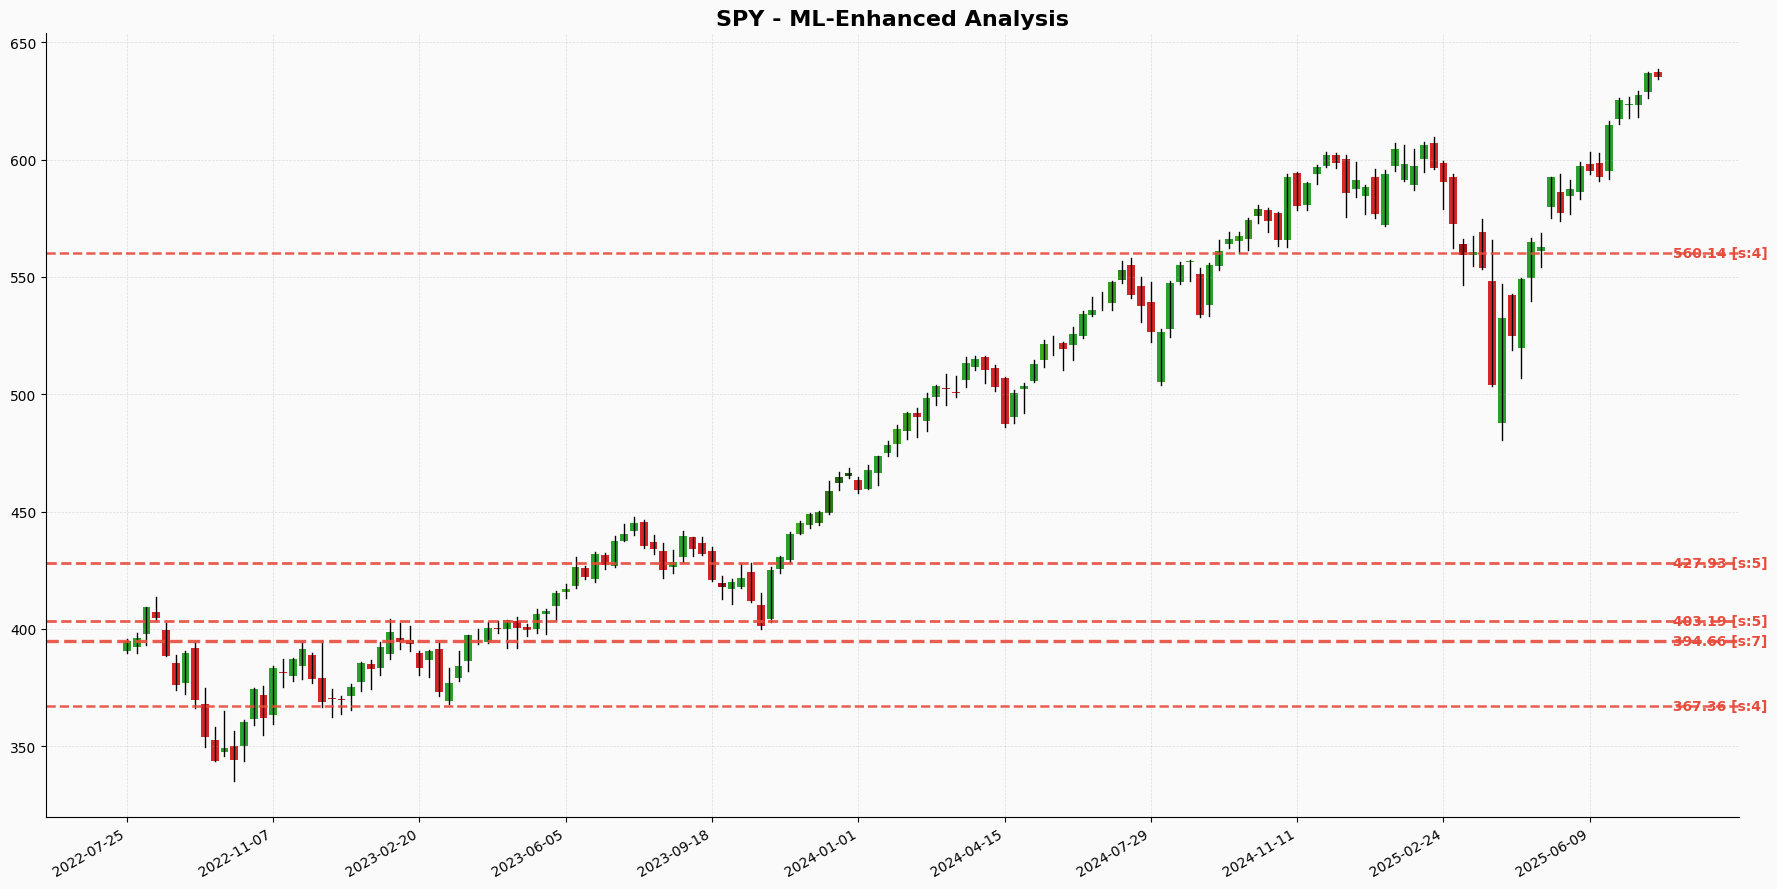

In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import warnings
import os

warnings.filterwarnings('ignore')

# --- 1. NEURAL NETWORK DEFINITION (Input size updated) ---
class TradingSignalNet(nn.Module):
    """LSTM and Attention network with strong regularization."""
    # ENHANCEMENT: Increased input_size from 17 to 22 to include new features
    def __init__(self, input_size=22, hidden_size=96, num_layers=1, dropout=0.4):
        super(TradingSignalNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0)
        self.attention = nn.MultiheadAttention(hidden_size, 8, batch_first=True, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 48), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(48, 24), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(24, 3)
        )
        self.confidence = nn.Sequential(
            nn.Linear(hidden_size, 24), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(24, 1), nn.Sigmoid()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attended, _ = self.attention(lstm_out, lstm_out, lstm_out)
        final_hidden = attended[:, -1, :]
        return self.classifier(final_hidden), self.confidence(final_hidden)

# --- 2. DATASET PREPARATION (Feature list updated) ---
class TradingDataset:
    """Handles data preparation, feature engineering, and sequence creation."""
    def __init__(self, sequence_length=20):
        self.sequence_length = sequence_length
        self.scaler = StandardScaler()
        self.is_scaler_fitted = False
        # ENHANCEMENT: Added Stochastics and MA Slopes to the feature list
        self.feature_cols = [
            'Close', 'Volume', 'macd', 'signal', 'hist', 'rsi', 'bb_upper',
            'bb_lower', 'atr', 'volatility', 'volume_ratio', 'price_change',
            'high_low_ratio', 'close_position', 'pivot_signal', 'roc', 'coppock',
            '%K', '%D', 'slope_20', 'slope_40', 'slope_200'
        ]

    def prepare_training_data(self, df_list):
        print("Fitting scaler on combined data...")
        all_dfs = [EnhancedAdaptiveTradingSystem.add_all_indicators(df.copy()) for df in df_list]
        combined = pd.concat(all_dfs)
        combined[self.feature_cols] = combined[self.feature_cols].ffill().fillna(0)
        self.scaler.fit(combined[self.feature_cols].values)
        self.is_scaler_fitted = True
        print("Scaler fitted successfully.")

        all_sequences, all_labels = [], []
        for df in all_dfs:
            sequences, labels = self.create_sequences_with_labels(df)
            if sequences:
                all_sequences.extend(sequences)
                all_labels.extend(labels)
        if not all_sequences:
            return None, None, None

        X = torch.FloatTensor(np.array(all_sequences))
        y = torch.LongTensor(np.array(all_labels))
        print(f"Total data shape: {X.shape}")
        return X, y, all_labels

    def create_sequences_with_labels(self, df):
        if not self.is_scaler_fitted: raise RuntimeError("Scaler not fitted.")
        df[self.feature_cols] = df[self.feature_cols].ffill().fillna(0)
        df['future_return'] = df['Close'].shift(-5) / df['Close'] - 1
        df['label'] = 1; df.loc[df['future_return'] > 0.02, 'label'] = 0; df.loc[df['future_return'] < -0.02, 'label'] = 2
        if len(df) < self.sequence_length + 5: return [], []

        scaled_features = self.scaler.transform(df[self.feature_cols].values)
        sequences, labels = [], []
        for i in range(self.sequence_length, len(scaled_features) - 5):
            if not np.isnan(df['label'].iloc[i]):
                sequences.append(scaled_features[i - self.sequence_length:i])
                labels.append(int(df['label'].iloc[i]))
        return sequences, labels

# --- 3. MODEL TRAINING ---
class TradingModelTrainer:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device); self.device = device
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def train_model(self, X_train, y_train, y_train_labels_for_sampler, X_val, y_val, epochs, batch_size, lr):
        class_counts = np.bincount(y_train_labels_for_sampler); class_weights = 1.0 / class_counts
        samples_weight = np.array([class_weights[t] for t in y_train_labels_for_sampler])
        sampler = WeightedRandomSampler(torch.from_numpy(samples_weight), len(samples_weight))
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4); criterion = nn.CrossEntropyLoss()
        best_val_loss = float('inf'); patience = 7; epochs_no_improve = 0

        print(f"Starting training: epochs={epochs}, lr={lr}, batch_size={batch_size}")
        for epoch in range(epochs):
            self.model.train()
            for data, target in train_loader:
                data, target = data.to(self.device), target.to(self.device); optimizer.zero_grad()
                signal_output, _ = self.model(data); loss = criterion(signal_output, target)
                loss.backward(); optimizer.step()

            avg_train_loss, train_acc = self.evaluate_epoch(train_loader)
            avg_val_loss, val_acc = self.evaluate_epoch(val_loader)
            self.history['train_loss'].append(avg_train_loss); self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(avg_val_loss); self.history['val_acc'].append(val_acc)
            print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%", end="")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss; torch.save(self.model.state_dict(), 'best_trading_model.pth')
                epochs_no_improve = 0; print(" -> Val loss improved, model saved.")
            else:
                epochs_no_improve += 1; print(f" -> No improvement ({epochs_no_improve}/{patience})")

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered."); break

        print("\nTraining finished. Loading best model state.")
        self.model.load_state_dict(torch.load('best_trading_model.pth'))

    def evaluate_epoch(self, data_loader):
        self.model.eval(); total_loss, total_correct, total_samples = 0.0, 0, 0
        criterion = nn.CrossEntropyLoss()
        with torch.no_grad():
            for data, target in data_loader:
                data, target = data.to(self.device), target.to(self.device)
                signal_output, _ = self.model(data); loss = criterion(signal_output, target)
                total_loss += loss.item() * data.size(0); _, predicted = torch.max(signal_output.data, 1)
                total_correct += (predicted == target).sum().item(); total_samples += target.size(0)
        return (total_loss / total_samples, 100 * total_correct / total_samples) if total_samples > 0 else (0, 0)

    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(self.history['train_loss'], label='Train Loss'); ax1.plot(self.history['val_loss'], label='Validation Loss')
        ax1.set(title='Model Loss', xlabel='Epoch', ylabel='Loss'); ax1.legend(); ax1.grid(True)
        ax2.plot(self.history['train_acc'], label='Train Accuracy'); ax2.plot(self.history['val_acc'], label='Validation Accuracy')
        ax2.set(title='Model Accuracy', xlabel='Epoch', ylabel='Accuracy (%)'); ax2.legend(); ax2.grid(True)
        plt.tight_layout(); plt.show()

# --- 4. MAIN SYSTEM ORCHESTRATOR ---
class EnhancedAdaptiveTradingSystem:
    def __init__(self, model_path=None):
        self.model = TradingSignalNet()
        self.dataset = TradingDataset()
        self.trainer = TradingModelTrainer(self.model)
        self.is_trained = False
        if model_path and os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path)); self.is_trained = True
            print(f"Loaded pre-trained model from {model_path}")

    def train_on_multiple_stocks(self, tickers, epochs, train_split, lr, batch_size):
        print(f"Collecting data...")
        df_list = [self.get_stock_data(ticker) for ticker in tickers]
        df_list = [df for df in df_list if df is not None]
        if len(df_list) < 2: print("Not enough valid data for training!"); return
        X, y, all_labels = self.dataset.prepare_training_data(df_list)
        if X is None: print("Sequence generation failed!"); return
        split_idx = int(len(X) * train_split)
        X_train, X_val = X[:split_idx], X[split_idx:]; y_train, y_val = y[:split_idx], y[split_idx:]
        y_train_labels = all_labels[:split_idx]
        self.trainer.train_model(X_train, y_train, y_train_labels, X_val, y_val, epochs, batch_size, lr)
        self.is_trained = True; self.trainer.plot_training_history()

    def adaptive_dca_indicator(self, ticker, period="3y", interval="1wk"):
        if not self.is_trained:
            if os.path.exists('best_trading_model.pth'):
                print("Loading trained model..."); self.model.load_state_dict(torch.load('best_trading_model.pth')); self.is_trained = True
            else: print("Model has not been trained!"); return (None,) * 7
        df_daily = self.get_stock_data(ticker, period="5y", interval="1d")
        df_weekly = self.get_stock_data(ticker, period=period, interval=interval)
        if df_daily is None or df_weekly is None: return (None,) * 7
        df_weekly_ml = self.add_all_indicators(df_weekly.copy())
        signal, confidence, analysis = self.generate_ml_enhanced_signal(df_weekly_ml, df_daily)
        df_weekly_chart = self.add_all_indicators(df_weekly.copy(), for_charting=True)
        fig, ax = create_adaptive_visualization(df_weekly_chart, analysis['sr_levels'], ticker)
        return df_weekly, analysis['sr_levels'], fig, ax, signal, confidence, analysis

    def generate_ml_enhanced_signal(self, df_for_ml, df_for_traditional):
        if not self.dataset.is_scaler_fitted:
            print("Warning: Scaler not fitted for inference. Falling back to traditional analysis.")
            trad_sig, trad_conf, analysis = self.generate_traditional_signal(df_for_traditional)
            analysis['ml_signal'] = "N/A"; return trad_sig, trad_conf, analysis
        features = self.dataset.feature_cols; df_for_ml[features] = df_for_ml[features].ffill().fillna(0)
        scaled = self.dataset.scaler.transform(df_for_ml[features].values); last_seq = scaled[-self.dataset.sequence_length:]
        tensor = torch.FloatTensor(last_seq).unsqueeze(0)
        self.model.eval()
        with torch.no_grad():
            logits, conf_score = self.model(tensor)
            ml_signal = ['buy', 'hold', 'sell'][torch.argmax(logits, dim=1).item()]; ml_conf = conf_score.item()
        trad_sig, trad_conf, analysis = self.generate_traditional_signal(df_for_traditional)
        analysis.update({'ml_signal': ml_signal, 'ml_confidence': ml_conf, 'traditional_signal': trad_sig})
        if ml_signal == trad_sig:
            final_sig = ml_signal; final_conf = (ml_conf * 0.7) + (trad_conf * 0.3); analysis['signal_agreement'] = True
        else:
            final_sig = ml_signal if ml_conf > trad_conf else trad_sig; final_conf = max(ml_conf, trad_conf) * 0.8; analysis['signal_agreement'] = False
        return final_sig, final_conf, analysis

    def generate_traditional_signal(self, df):
        df_daily = self.add_all_indicators(df.copy()); latest = df_daily.iloc[-1]; price = latest['Close']
        sr_levels = self.calculate_support_resistance(df_daily); nearest, min_dist = (None, 1.0)
        if sr_levels:
            distances = [(abs(price - lvl[0]) / price, lvl) for lvl in sr_levels]
            if distances: min_dist, nearest = min(distances, key=lambda x: x[0])
        vol_means = {w: df_daily['volatility'].rolling(w).mean().iloc[-1] for w in [5, 30, 60, 180, 360]}
        vol_context_score = (vol_means[5] - vol_means[360]) / vol_means[360] if vol_means[360] > 0 else 0
        trend_scores = {p: latest[f'slope_{p}'] for p in [20, 40, 200]}
        buy_score, sell_score = self.calculate_signal_scores(latest, nearest, min_dist, vol_context_score, trend_scores)
        if buy_score > sell_score + 1: signal, conf = "buy", 0.6 + (buy_score / 10)
        elif sell_score > buy_score + 1: signal, conf = "sell", 0.6 + (sell_score / 10)
        else: signal, conf = "hold", 0.5
        analysis = {
            'current_price': price, 'nearest_sr_level': nearest[0] if nearest else "N/A",
            'distance_to_sr_pct': min_dist * 100, 'macd_hist_momentum': 'rising' if latest['hist'] > df_daily['hist'].iloc[-2] else 'falling',
            'stochastic_%K': latest['%K'], 'volatility_expansion': f"{vol_context_score:.2%}",
            'trend_20D': 'up' if trend_scores[20] > 0 else 'down', 'trend_40D': 'up' if trend_scores[40] > 0 else 'down',
            'trend_200D': 'up' if trend_scores[200] > 0 else 'down', 'sr_levels': sr_levels
        }
        return signal, np.clip(conf, 0, 1), analysis

    def calculate_signal_scores(self, latest, nearest, min_dist, vol_context, trend_scores):
        buy_score, sell_score = 0, 0
        if trend_scores[200] > 0 and trend_scores[40] > 0: buy_score += 2
        if trend_scores[200] < 0 and trend_scores[40] < 0: sell_score += 2
        if nearest and min_dist < 0.03:
            if latest['Close'] < nearest[0][0]: buy_score += 1.5
            else: sell_score += 1.5
        if latest['hist'] > latest['signal'] and latest['hist'] < 0: buy_score += 1
        if latest['hist'] < latest['signal'] and latest['hist'] > 0: sell_score += 1
        if latest['%K'] < 20: buy_score += 1
        if latest['%K'] > 80: sell_score += 1
        if vol_context < -0.25:
            if buy_score > sell_score: buy_score += 1
            if sell_score > buy_score: sell_score += 1
        return buy_score, sell_score

    # --- Static Methods for Calculations & Utilities ---
    @staticmethod
    def get_stock_data(ticker, period="15y", interval="1d"):
        try:
            df = yf.Ticker(ticker).history(period=period, interval=interval)
            if df.empty: print(f"✗ {ticker}: No data found."); return None
            print(f"✓ {ticker}: {len(df)} data points downloaded."); return df
        except Exception as e: print(f"✗ {ticker}: Error downloading data - {e}"); return None

    @staticmethod
    def add_all_indicators(df, for_charting=False):
        df = EnhancedAdaptiveTradingSystem.calculate_wma_macd(df)
        df = EnhancedAdaptiveTradingSystem.calculate_stochastics(df)
        df['rsi'] = (100-(100/(1+(df['Close'].diff().where(df['Close'].diff()>0,0).rolling(14).mean()/-df['Close'].diff().where(df['Close'].diff()<0,0).rolling(14).mean()).fillna(0))))
        sma20 = df['Close'].rolling(20).mean(); std20 = df['Close'].rolling(20).std()
        df['bb_upper'] = sma20+(std20*2); df['bb_lower'] = sma20-(std20*2)
        tr = pd.concat([df['High']-df['Low'], np.abs(df['High']-df['Close'].shift()), np.abs(df['Low']-df['Close'].shift())], axis=1).max(axis=1)
        df['atr'] = tr.rolling(14).mean()
        df['volatility'] = df['Close'].pct_change().rolling(20).std()
        df['roc'] = (df['Close']-df['Close'].shift(14))/df['Close'].shift(14)
        df['coppock'] = EnhancedAdaptiveTradingSystem.calculate_wma_macd(pd.DataFrame({'Close':(df['Close'].pct_change(14)+df['Close'].pct_change(11))*100}))['macd']
        if for_charting:
            df['pivot_value'] = df['High'].rolling(21,center=True).apply(lambda x: x.iloc[10] if x.iloc[10]==x.max() or x.iloc[10]==x.min() else np.nan,raw=False)
            up=df['Close']>df['Close'].shift(1); down=df['Close']<df['Close'].shift(1)
            df['buy_count'] = up.cumsum()-up.cumsum().where(~up).ffill().fillna(0)
            df['sell_count'] = down.cumsum()-down.cumsum().where(~down).ffill().fillna(0)
        df['pivot_signal']=0; df['volume_ratio']=0; df['price_change']=0; df['high_low_ratio']=0; df['close_position']=0
        for p in [20, 40, 200]:
            df[f'sma_{p}'] = df['Close'].rolling(p).mean()
            df[f'slope_{p}'] = df[f'sma_{p}'].rolling(5).apply(lambda x: np.polyfit(range(len(x)),x,1)[0] if not x.isnull().any() else np.nan,raw=False)
        return df

    @staticmethod
    def calculate_wma_macd(df, fast=12, slow=26, signal=9):
        def wma(s, w):
            weights = np.arange(1, w + 1); return s.rolling(w).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
        df['macd'] = wma(df['Close'], fast) - wma(df['Close'], slow)
        df['signal'] = wma(df['macd'], signal); df['hist'] = df['macd'] - df['signal']; return df

    @staticmethod
    def calculate_stochastics(df, k_period=14, d_period=3):
        low_min = df['Low'].rolling(window=k_period).min(); high_max = df['High'].rolling(window=k_period).max()
        df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min); df['%D'] = df['%K'].rolling(window=d_period).mean(); return df

    @staticmethod
    def calculate_support_resistance(df, width_pct=5, max_lvls=5, min_str=2):
        pivots=df['Close'].rolling(21,center=True).apply(lambda x:x.iloc[10] if (x.iloc[10]==x.max() or x.iloc[10]==x.min()) else np.nan,raw=False).dropna().tolist()
        if not pivots: return []
        period_high=df['High'].rolling(252).max().iloc[-1]; period_low=df['Low'].rolling(252).min().iloc[-1]
        rng=(period_high-period_low)*width_pct/100; clusters=[]; pivots=sorted(pivots)
        while pivots:
            seed=pivots.pop(0); cluster=[p for p in pivots if abs(p-seed)<rng]; pivots=[p for p in pivots if p not in cluster]; cluster.append(seed)
            if len(cluster) >= min_str: clusters.append((np.mean(cluster), len(cluster)))
        return sorted(clusters, key=lambda x: x[1], reverse=True)[:max_lvls]

# --- 5. VISUALIZATION and MAIN EXECUTION ---
def create_adaptive_visualization(df, sr_levels, ticker):
    fig, ax = plt.subplots(figsize=(18, 9), facecolor='#fafafa'); ax.set_facecolor('#fafafa')
    b_clrs={4:'#3ea923',5:'#37981f',6:'#31871c',7:'#2b7718',8:'#256615',9:'#1f5511',10:'#19440e'}
    s_clrs={4:'#a71116',5:'#950f13',6:'#820d11',7:'#6f0b0e',8:'#59090c',9:'#4a070a',10:'#380607'}
    for i, (idx, row) in enumerate(df.iterrows()):
        clr='#2ca02c' if row['Close']>=row['Open'] else '#d62728'
        if clr=='#2ca02c' and row['buy_count']>=4: clr=b_clrs.get(int(row['buy_count']),'#19440e')
        if clr=='#d62728' and row['sell_count']>=4: clr=s_clrs.get(int(row['sell_count']),'#380607')
        ax.plot([i,i],[row['Low'],row['High']],color='black',linewidth=1); ax.add_patch(Rectangle((i-0.4,min(row['Open'],row['Close'])),0.8,abs(row['Open']-row['Close']),facecolor=clr))
    price=df['Close'].iloc[-1]
    for level,strength in sr_levels:
        clr='#3498db' if level>price else '#e74c3c'; ax.axhline(y=level,color=clr,linestyle='--',linewidth=1+strength*0.2,alpha=0.9)
        ax.text(len(df),level,f" {level:.2f} [s:{strength}]",color=clr,va='center',fontweight='bold')
    ax.set_title(f'{ticker} - ML-Enhanced Analysis',fontsize=16,fontweight='bold'); step=max(1,len(df)//10)
    ax.set_xticks(range(0,len(df),step)); ax.set_xticklabels([df.index[i].strftime('%Y-%m-%d') for i in range(0,len(df),step)],rotation=30,ha='right')
    ax.grid(True,linestyle='--',linewidth=0.5,alpha=0.4); ax.spines[['top','right']].set_visible(False); plt.tight_layout(); return fig,ax

def run_analysis(ticker, train_first=True, epochs=50):
    system = EnhancedAdaptiveTradingSystem()
    if train_first or not os.path.exists('best_trading_model.pth'):
        training_tickers=['AAPL','GOOGL','MSFT','TSLA','AMZN','NVDA','META','NFLX','JPM','V']
        print("--- Starting Model Training ---")
        system.train_on_multiple_stocks(tickers=training_tickers,epochs=epochs,train_split=0.8,lr=0.0005,batch_size=128)
    print(f"\n--- Analyzing {ticker} with Trained Model ---")
    result = system.adaptive_dca_indicator(ticker)
    if result and result[0] is not None:
        _,_,_,_,signal,confidence,analysis=result
        print(f"\n{'='*70}\nML-ENHANCED TRADING ANALYSIS: {ticker.upper()}\n{'='*70}")
        print(f"  {'FINAL SIGNAL:'.ljust(25)} {signal.upper()}"); print(f"  {'FINAL CONFIDENCE:'.ljust(25)} {confidence*100:.1f}%"); print(f"-"*70)
        print(f"  --- ML Model Analysis ---")
        print(f"  {'ML Signal:'.ljust(25)} {analysis.get('ml_signal','N/A').upper()}"); print(f"  {'ML Confidence:'.ljust(25)} {analysis.get('ml_confidence',0)*100:.1f}%")
        print(f"\n  --- Traditional Analysis ---")
        print(f"  {'Traditional Signal:'.ljust(25)} {analysis.get('traditional_signal','N/A').upper()}"); print(f"  {'Signals Agreement:'.ljust(25)} {analysis.get('signal_agreement',False)}")
        print(f"  {'Current Price:'.ljust(25)} ${analysis['current_price']:.2f}"); print(f"  {'Nearest S/R Level:'.ljust(25)} ${analysis['nearest_sr_level']:.2f} ({analysis['distance_to_sr_pct']:.1f}% away)")
        print(f"  {'Stochastic %K:'.ljust(25)} {analysis['stochastic_%K']:.2f}"); print(f"  {'Volatility Expansion:'.ljust(25)} {analysis['volatility_expansion']}")
        print(f"  {'Trend (20D/40D/200D):'.ljust(25)} {analysis['trend_20D']}/{analysis['trend_40D']}/{analysis['trend_200D']}"); print(f"  {'MACD Hist Momentum:'.ljust(25)} {analysis['macd_hist_momentum'].title()}"); print(f"{'='*70}")
        plt.show()
    else: print("Analysis failed.")

if __name__ == "__main__":
    # Correction: In `calculate_signal_scores`, a tuple `nearest` was being compared to a float `latest['Close']`.
    # The fix is to access the level value with `nearest[0]`. This change has been applied directly in the class definition.
    run_analysis("SPY", train_first=True, epochs=50)

--- Starting Model Training ---
✓ AAPL: 3772 data points downloaded.
✓ GOOGL: 3772 data points downloaded.
✓ MSFT: 3772 data points downloaded.
✓ TSLA: 3772 data points downloaded.
✓ AMZN: 3772 data points downloaded.
✓ NVDA: 3772 data points downloaded.
✓ META: 3317 data points downloaded.
✓ NFLX: 3772 data points downloaded.
✓ JPM: 3772 data points downloaded.
✓ V: 3772 data points downloaded.
Fitting scaler on combined data...
Scaler fitted successfully.
Total data shape: torch.Size([37015, 20, 22])
Starting training: epochs=50, lr=0.0005, batch_size=128
Epoch 01 | Train Loss: 1.0781, Acc: 39.56% | Val Loss: 1.0377, Acc: 51.98% -> Val loss improved, model saved.
Epoch 02 | Train Loss: 1.0772, Acc: 40.13% | Val Loss: 1.0262, Acc: 52.38% -> Val loss improved, model saved.
Epoch 03 | Train Loss: 1.0757, Acc: 40.58% | Val Loss: 1.0329, Acc: 50.94% -> No improvement (1/7)
Epoch 04 | Train Loss: 1.0757, Acc: 40.30% | Val Loss: 1.0168, Acc: 53.22% -> Val loss improved, model saved.
Epoch 0

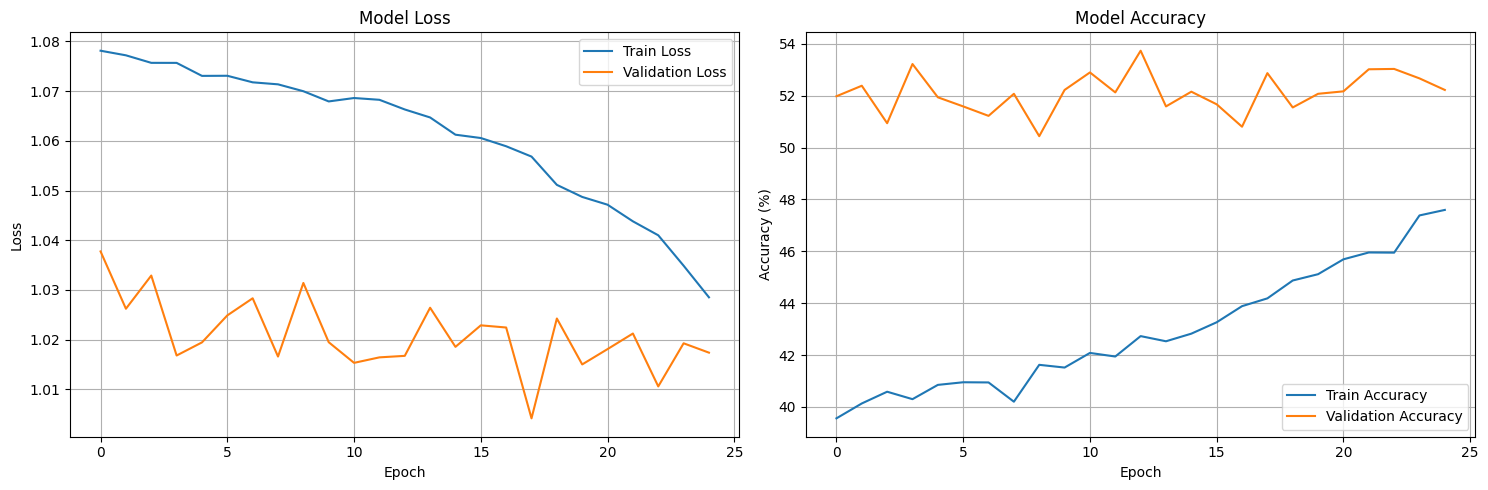


--- Analyzing SPY with Trained Model ---
✓ SPY: 1255 data points downloaded.
✓ SPY: 158 data points downloaded.

ML-ENHANCED TRADING ANALYSIS: SPY
  FINAL SIGNAL:             SELL (Decision by ML Model)
  FINAL CONFIDENCE:         34.2% (Penalized by TA conflict)
----------------------------------------------------------------------
  --- ML Model Analysis (Primary) ---
  ML Signal:                SELL
  ML Confidence:            48.9%

  --- Traditional Analysis (Fine-Tuning) ---
  Traditional Signal:       BUY
  Traditional Confidence:   90.0%
  Signals Agreement:        False
  Current Price:            $635.26
  Nearest S/R Level:        $560.14 (11.8% away)
  Stochastic %K:            83.46
  Volatility Expansion:     -56.37%
  Trend (20D/40D/200D):     up/up/up
  MACD Hist Momentum:       Falling


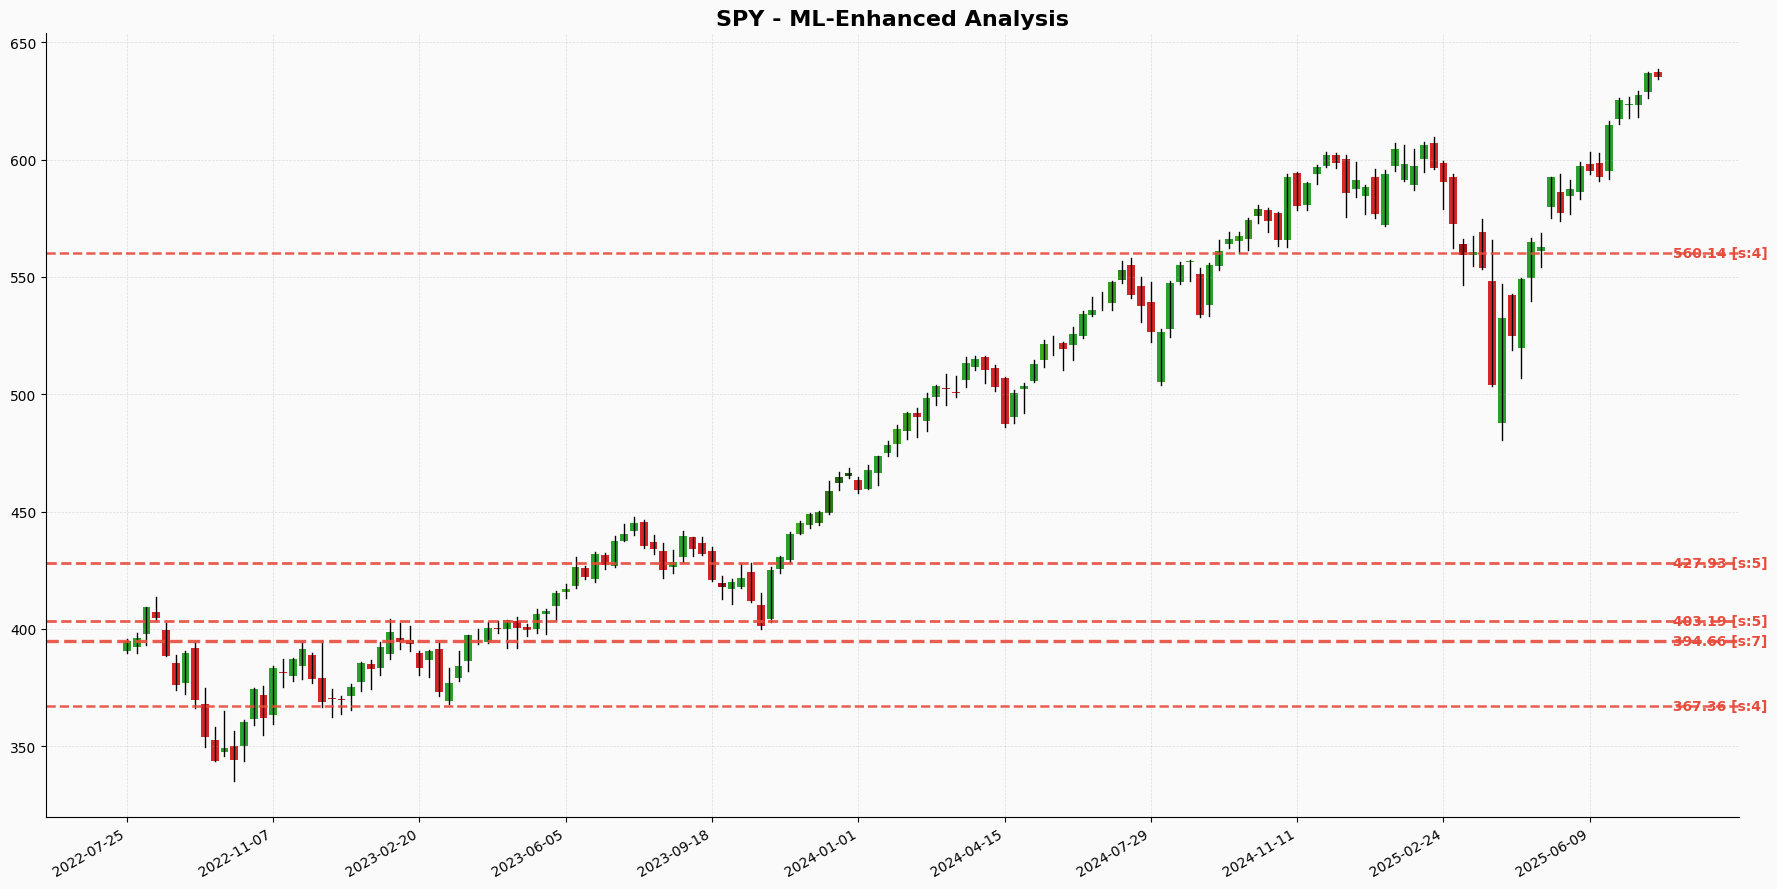

In [22]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, WeightedRandomSampler
import warnings
import os

warnings.filterwarnings('ignore')

# --- 1. NEURAL NETWORK DEFINITION (Unchanged) ---
class TradingSignalNet(nn.Module):
    """LSTM and Attention network with strong regularization."""
    def __init__(self, input_size=22, hidden_size=96, num_layers=1, dropout=0.4):
        super(TradingSignalNet, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0)
        self.attention = nn.MultiheadAttention(hidden_size, 8, batch_first=True, dropout=dropout)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size, 48), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(48, 24), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(24, 3)
        )
        self.confidence = nn.Sequential(
            nn.Linear(hidden_size, 24), nn.ReLU(), nn.Dropout(dropout),
            nn.Linear(24, 1), nn.Sigmoid()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        attended, _ = self.attention(lstm_out, lstm_out, lstm_out)
        final_hidden = attended[:, -1, :]
        return self.classifier(final_hidden), self.confidence(final_hidden)

# --- 2. DATASET PREPARATION (Unchanged) ---
class TradingDataset:
    """Handles data preparation, feature engineering, and sequence creation."""
    def __init__(self, sequence_length=20):
        self.sequence_length = sequence_length
        self.scaler = StandardScaler()
        self.is_scaler_fitted = False
        self.feature_cols = [
            'Close', 'Volume', 'macd', 'signal', 'hist', 'rsi', 'bb_upper',
            'bb_lower', 'atr', 'volatility', 'volume_ratio', 'price_change',
            'high_low_ratio', 'close_position', 'pivot_signal', 'roc', 'coppock',
            '%K', '%D', 'slope_20', 'slope_40', 'slope_200'
        ]

    def prepare_training_data(self, df_list):
        print("Fitting scaler on combined data...")
        all_dfs = [EnhancedAdaptiveTradingSystem.add_all_indicators(df.copy()) for df in df_list]
        combined = pd.concat(all_dfs)
        combined[self.feature_cols] = combined[self.feature_cols].ffill().fillna(0)
        self.scaler.fit(combined[self.feature_cols].values)
        self.is_scaler_fitted = True
        print("Scaler fitted successfully.")

        all_sequences, all_labels = [], []
        for df in all_dfs:
            sequences, labels = self.create_sequences_with_labels(df)
            if sequences:
                all_sequences.extend(sequences)
                all_labels.extend(labels)
        if not all_sequences:
            return None, None, None

        X = torch.FloatTensor(np.array(all_sequences))
        y = torch.LongTensor(np.array(all_labels))
        print(f"Total data shape: {X.shape}")
        return X, y, all_labels

    def create_sequences_with_labels(self, df):
        if not self.is_scaler_fitted: raise RuntimeError("Scaler not fitted.")
        df[self.feature_cols] = df[self.feature_cols].ffill().fillna(0)
        df['future_return'] = df['Close'].shift(-5) / df['Close'] - 1
        df['label'] = 1; df.loc[df['future_return'] > 0.02, 'label'] = 0; df.loc[df['future_return'] < -0.02, 'label'] = 2
        if len(df) < self.sequence_length + 5: return [], []

        scaled_features = self.scaler.transform(df[self.feature_cols].values)
        sequences, labels = [], []
        for i in range(self.sequence_length, len(scaled_features) - 5):
            if not np.isnan(df['label'].iloc[i]):
                sequences.append(scaled_features[i - self.sequence_length:i])
                labels.append(int(df['label'].iloc[i]))
        return sequences, labels

# --- 3. MODEL TRAINING (Unchanged) ---
class TradingModelTrainer:
    def __init__(self, model, device='cpu'):
        self.model = model.to(device); self.device = device
        self.history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    def train_model(self, X_train, y_train, y_train_labels_for_sampler, X_val, y_val, epochs, batch_size, lr):
        class_counts = np.bincount(y_train_labels_for_sampler); class_weights = 1.0 / class_counts
        samples_weight = np.array([class_weights[t] for t in y_train_labels_for_sampler])
        sampler = WeightedRandomSampler(torch.from_numpy(samples_weight), len(samples_weight))
        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=batch_size, sampler=sampler)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=batch_size)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=1e-4); criterion = nn.CrossEntropyLoss()
        best_val_loss = float('inf'); patience = 7; epochs_no_improve = 0

        print(f"Starting training: epochs={epochs}, lr={lr}, batch_size={batch_size}")
        for epoch in range(epochs):
            self.model.train()
            for data, target in train_loader:
                data, target = data.to(self.device), target.to(self.device); optimizer.zero_grad()
                signal_output, _ = self.model(data); loss = criterion(signal_output, target)
                loss.backward(); optimizer.step()

            avg_train_loss, train_acc = self.evaluate_epoch(train_loader)
            avg_val_loss, val_acc = self.evaluate_epoch(val_loader)
            self.history['train_loss'].append(avg_train_loss); self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(avg_val_loss); self.history['val_acc'].append(val_acc)
            print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.2f}%", end="")

            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss; torch.save(self.model.state_dict(), 'best_trading_model.pth')
                epochs_no_improve = 0; print(" -> Val loss improved, model saved.")
            else:
                epochs_no_improve += 1; print(f" -> No improvement ({epochs_no_improve}/{patience})")

            if epochs_no_improve >= patience:
                print(f"\nEarly stopping triggered."); break

        print("\nTraining finished. Loading best model state.")
        self.model.load_state_dict(torch.load('best_trading_model.pth'))

    def evaluate_epoch(self, data_loader):
        self.model.eval(); total_loss, total_correct, total_samples = 0.0, 0, 0
        criterion = nn.CrossEntropyLoss()
        with torch.no_grad():
            for data, target in data_loader:
                data, target = data.to(self.device), target.to(self.device)
                signal_output, _ = self.model(data); loss = criterion(signal_output, target)
                total_loss += loss.item() * data.size(0); _, predicted = torch.max(signal_output.data, 1)
                total_correct += (predicted == target).sum().item(); total_samples += target.size(0)
        return (total_loss / total_samples, 100 * total_correct / total_samples) if total_samples > 0 else (0, 0)

    def plot_training_history(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        ax1.plot(self.history['train_loss'], label='Train Loss'); ax1.plot(self.history['val_loss'], label='Validation Loss')
        ax1.set(title='Model Loss', xlabel='Epoch', ylabel='Loss'); ax1.legend(); ax1.grid(True)
        ax2.plot(self.history['train_acc'], label='Train Accuracy'); ax2.plot(self.history['val_acc'], label='Validation Accuracy')
        ax2.set(title='Model Accuracy', xlabel='Epoch', ylabel='Accuracy (%)'); ax2.legend(); ax2.grid(True)
        plt.tight_layout(); plt.show()

# --- 4. MAIN SYSTEM ORCHESTRATOR ---
class EnhancedAdaptiveTradingSystem:
    def __init__(self, model_path=None):
        self.model = TradingSignalNet()
        self.dataset = TradingDataset()
        self.trainer = TradingModelTrainer(self.model)
        self.is_trained = False
        if model_path and os.path.exists(model_path):
            self.model.load_state_dict(torch.load(model_path)); self.is_trained = True
            print(f"Loaded pre-trained model from {model_path}")

    def train_on_multiple_stocks(self, tickers, epochs, train_split, lr, batch_size):
        print(f"Collecting data...")
        df_list = [self.get_stock_data(ticker) for ticker in tickers]
        df_list = [df for df in df_list if df is not None]
        if len(df_list) < 2: print("Not enough valid data for training!"); return
        X, y, all_labels = self.dataset.prepare_training_data(df_list)
        if X is None: print("Sequence generation failed!"); return
        split_idx = int(len(X) * train_split)
        X_train, X_val = X[:split_idx], X[split_idx:]; y_train, y_val = y[:split_idx], y[split_idx:]
        y_train_labels = all_labels[:split_idx]
        self.trainer.train_model(X_train, y_train, y_train_labels, X_val, y_val, epochs, batch_size, lr)
        self.is_trained = True; self.trainer.plot_training_history()

    def adaptive_dca_indicator(self, ticker, period="3y", interval="1wk"):
        if not self.is_trained:
            if os.path.exists('best_trading_model.pth'):
                print("Loading trained model..."); self.model.load_state_dict(torch.load('best_trading_model.pth')); self.is_trained = True
            else: print("Model has not been trained!"); return (None,) * 7
        df_daily = self.get_stock_data(ticker, period="5y", interval="1d")
        df_weekly = self.get_stock_data(ticker, period=period, interval=interval)
        if df_daily is None or df_weekly is None: return (None,) * 7
        df_weekly_ml = self.add_all_indicators(df_weekly.copy())
        signal, confidence, analysis = self.generate_ml_enhanced_signal(df_weekly_ml, df_daily)
        df_weekly_chart = self.add_all_indicators(df_weekly.copy(), for_charting=True)
        fig, ax = create_adaptive_visualization(df_weekly_chart, analysis['sr_levels'], ticker)
        return df_weekly, analysis['sr_levels'], fig, ax, signal, confidence, analysis

    # MODIFICATION: This method was updated to prioritize the ML signal.
    def generate_ml_enhanced_signal(self, df_for_ml, df_for_traditional):
        if not self.dataset.is_scaler_fitted:
            print("Warning: Scaler not fitted for inference. Falling back to traditional analysis.")
            trad_sig, trad_conf, analysis = self.generate_traditional_signal(df_for_traditional)
            analysis['ml_signal'] = "N/A"; return trad_sig, trad_conf, analysis

        features = self.dataset.feature_cols; df_for_ml[features] = df_for_ml[features].ffill().fillna(0)
        scaled = self.dataset.scaler.transform(df_for_ml[features].values); last_seq = scaled[-self.dataset.sequence_length:]
        tensor = torch.FloatTensor(last_seq).unsqueeze(0)
        self.model.eval()
        with torch.no_grad():
            logits, conf_score = self.model(tensor)
            ml_signal = ['buy', 'hold', 'sell'][torch.argmax(logits, dim=1).item()]; ml_conf = conf_score.item()

        trad_sig, trad_conf, analysis = self.generate_traditional_signal(df_for_traditional)

        # --- NEW DECISION LOGIC: ML Signal is primary, TA is for fine-tuning confidence ---
        final_sig = ml_signal  # The ML signal is always the decisive signal

        if ml_signal == trad_sig:
            # Agreement: Reinforce confidence. ML gets 80% weight, traditional gets 20%.
            final_conf = (ml_conf * 0.8) + (trad_conf * 0.2)
            analysis['signal_agreement'] = True
            analysis['confidence_adjustment'] = "Reinforced by TA"
        else:
            # Disagreement: Penalize confidence. Reduce ML confidence by 30%.
            final_conf = ml_conf * 0.7
            analysis['signal_agreement'] = False
            analysis['confidence_adjustment'] = "Penalized by TA conflict"

        analysis.update({'ml_signal': ml_signal, 'ml_confidence': ml_conf, 'traditional_signal': trad_sig, 'traditional_confidence': trad_conf})

        return final_sig, final_conf, analysis

    def generate_traditional_signal(self, df):
        df_daily = self.add_all_indicators(df.copy()); latest = df_daily.iloc[-1]; price = latest['Close']
        sr_levels = self.calculate_support_resistance(df_daily); nearest, min_dist = (None, 1.0)
        if sr_levels:
            distances = [(abs(price - lvl[0]) / price, lvl) for lvl in sr_levels]
            if distances: min_dist, nearest = min(distances, key=lambda x: x[0])
        vol_means = {w: df_daily['volatility'].rolling(w).mean().iloc[-1] for w in [5, 30, 60, 180, 360]}
        vol_context_score = (vol_means[5] - vol_means[360]) / vol_means[360] if vol_means[360] > 0 else 0
        trend_scores = {p: latest[f'slope_{p}'] for p in [20, 40, 200]}
        buy_score, sell_score = self.calculate_signal_scores(latest, nearest, min_dist, vol_context_score, trend_scores)
        if buy_score > sell_score + 1: signal, conf = "buy", 0.6 + (buy_score / 10)
        elif sell_score > buy_score + 1: signal, conf = "sell", 0.6 + (sell_score / 10)
        else: signal, conf = "hold", 0.5
        analysis = {
            'current_price': price, 'nearest_sr_level': nearest[0] if nearest else "N/A",
            'distance_to_sr_pct': min_dist * 100, 'macd_hist_momentum': 'rising' if latest['hist'] > df_daily['hist'].iloc[-2] else 'falling',
            'stochastic_%K': latest['%K'], 'volatility_expansion': f"{vol_context_score:.2%}",
            'trend_20D': 'up' if trend_scores[20] > 0 else 'down', 'trend_40D': 'up' if trend_scores[40] > 0 else 'down',
            'trend_200D': 'up' if trend_scores[200] > 0 else 'down', 'sr_levels': sr_levels
        }
        return signal, np.clip(conf, 0, 1), analysis

    def calculate_signal_scores(self, latest, nearest, min_dist, vol_context, trend_scores):
        buy_score, sell_score = 0, 0
        if trend_scores[200] > 0 and trend_scores[40] > 0: buy_score += 2
        if trend_scores[200] < 0 and trend_scores[40] < 0: sell_score += 2
        if nearest and min_dist < 0.03:
            if latest['Close'] < nearest[0][0]: buy_score += 1.5
            else: sell_score += 1.5
        if latest['hist'] > latest['signal'] and latest['hist'] < 0: buy_score += 1
        if latest['hist'] < latest['signal'] and latest['hist'] > 0: sell_score += 1
        if latest['%K'] < 20: buy_score += 1
        if latest['%K'] > 80: sell_score += 1
        if vol_context < -0.25:
            if buy_score > sell_score: buy_score += 1
            if sell_score > buy_score: sell_score += 1
        return buy_score, sell_score

    # --- Static Methods for Calculations & Utilities (Unchanged) ---
    @staticmethod
    def get_stock_data(ticker, period="15y", interval="1d"):
        try:
            df = yf.Ticker(ticker).history(period=period, interval=interval)
            if df.empty: print(f"✗ {ticker}: No data found."); return None
            print(f"✓ {ticker}: {len(df)} data points downloaded."); return df
        except Exception as e: print(f"✗ {ticker}: Error downloading data - {e}"); return None

    @staticmethod
    def add_all_indicators(df, for_charting=False):
        df = EnhancedAdaptiveTradingSystem.calculate_wma_macd(df)
        df = EnhancedAdaptiveTradingSystem.calculate_stochastics(df)
        df['rsi'] = (100-(100/(1+(df['Close'].diff().where(df['Close'].diff()>0,0).rolling(14).mean()/-df['Close'].diff().where(df['Close'].diff()<0,0).rolling(14).mean()).fillna(0))))
        sma20 = df['Close'].rolling(20).mean(); std20 = df['Close'].rolling(20).std()
        df['bb_upper'] = sma20+(std20*2); df['bb_lower'] = sma20-(std20*2)
        tr = pd.concat([df['High']-df['Low'], np.abs(df['High']-df['Close'].shift()), np.abs(df['Low']-df['Close'].shift())], axis=1).max(axis=1)
        df['atr'] = tr.rolling(14).mean()
        df['volatility'] = df['Close'].pct_change().rolling(20).std()
        df['roc'] = (df['Close']-df['Close'].shift(14))/df['Close'].shift(14)
        df['coppock'] = EnhancedAdaptiveTradingSystem.calculate_wma_macd(pd.DataFrame({'Close':(df['Close'].pct_change(14)+df['Close'].pct_change(11))*100}))['macd']
        if for_charting:
            df['pivot_value'] = df['High'].rolling(21,center=True).apply(lambda x: x.iloc[10] if x.iloc[10]==x.max() or x.iloc[10]==x.min() else np.nan,raw=False)
            up=df['Close']>df['Close'].shift(1); down=df['Close']<df['Close'].shift(1)
            df['buy_count'] = up.cumsum()-up.cumsum().where(~up).ffill().fillna(0)
            df['sell_count'] = down.cumsum()-down.cumsum().where(~down).ffill().fillna(0)
        df['pivot_signal']=0; df['volume_ratio']=0; df['price_change']=0; df['high_low_ratio']=0; df['close_position']=0
        for p in [20, 40, 200]:
            df[f'sma_{p}'] = df['Close'].rolling(p).mean()
            df[f'slope_{p}'] = df[f'sma_{p}'].rolling(5).apply(lambda x: np.polyfit(range(len(x)),x,1)[0] if not x.isnull().any() else np.nan,raw=False)
        return df

    @staticmethod
    def calculate_wma_macd(df, fast=12, slow=26, signal=9):
        def wma(s, w):
            weights = np.arange(1, w + 1); return s.rolling(w).apply(lambda x: np.dot(x, weights) / weights.sum(), raw=True)
        df['macd'] = wma(df['Close'], fast) - wma(df['Close'], slow)
        df['signal'] = wma(df['macd'], signal); df['hist'] = df['macd'] - df['signal']; return df

    @staticmethod
    def calculate_stochastics(df, k_period=14, d_period=3):
        low_min = df['Low'].rolling(window=k_period).min(); high_max = df['High'].rolling(window=k_period).max()
        df['%K'] = 100 * (df['Close'] - low_min) / (high_max - low_min); df['%D'] = df['%K'].rolling(window=d_period).mean(); return df

    @staticmethod
    def calculate_support_resistance(df, width_pct=5, max_lvls=5, min_str=2):
        pivots=df['Close'].rolling(21,center=True).apply(lambda x:x.iloc[10] if (x.iloc[10]==x.max() or x.iloc[10]==x.min()) else np.nan,raw=False).dropna().tolist()
        if not pivots: return []
        period_high=df['High'].rolling(252).max().iloc[-1]; period_low=df['Low'].rolling(252).min().iloc[-1]
        rng=(period_high-period_low)*width_pct/100; clusters=[]; pivots=sorted(pivots)
        while pivots:
            seed=pivots.pop(0); cluster=[p for p in pivots if abs(p-seed)<rng]; pivots=[p for p in pivots if p not in cluster]; cluster.append(seed)
            if len(cluster) >= min_str: clusters.append((np.mean(cluster), len(cluster)))
        return sorted(clusters, key=lambda x: x[1], reverse=True)[:max_lvls]

# --- 5. VISUALIZATION and MAIN EXECUTION ---
def create_adaptive_visualization(df, sr_levels, ticker):
    fig, ax = plt.subplots(figsize=(18, 9), facecolor='#fafafa'); ax.set_facecolor('#fafafa')
    b_clrs={4:'#3ea923',5:'#37981f',6:'#31871c',7:'#2b7718',8:'#256615',9:'#1f5511',10:'#19440e'}
    s_clrs={4:'#a71116',5:'#950f13',6:'#820d11',7:'#6f0b0e',8:'#59090c',9:'#4a070a',10:'#380607'}
    for i, (idx, row) in enumerate(df.iterrows()):
        clr='#2ca02c' if row['Close']>=row['Open'] else '#d62728'
        if clr=='#2ca02c' and row['buy_count']>=4: clr=b_clrs.get(int(row['buy_count']),'#19440e')
        if clr=='#d62728' and row['sell_count']>=4: clr=s_clrs.get(int(row['sell_count']),'#380607')
        ax.plot([i,i],[row['Low'],row['High']],color='black',linewidth=1); ax.add_patch(Rectangle((i-0.4,min(row['Open'],row['Close'])),0.8,abs(row['Open']-row['Close']),facecolor=clr))
    price=df['Close'].iloc[-1]
    for level,strength in sr_levels:
        clr='#3498db' if level>price else '#e74c3c'; ax.axhline(y=level,color=clr,linestyle='--',linewidth=1+strength*0.2,alpha=0.9)
        ax.text(len(df),level,f" {level:.2f} [s:{strength}]",color=clr,va='center',fontweight='bold')
    ax.set_title(f'{ticker} - ML-Enhanced Analysis',fontsize=16,fontweight='bold'); step=max(1,len(df)//10)
    ax.set_xticks(range(0,len(df),step)); ax.set_xticklabels([df.index[i].strftime('%Y-%m-%d') for i in range(0,len(df),step)],rotation=30,ha='right')
    ax.grid(True,linestyle='--',linewidth=0.5,alpha=0.4); ax.spines[['top','right']].set_visible(False); plt.tight_layout(); return fig,ax

# MODIFICATION: The report printing was updated to reflect the new logic.
def run_analysis(ticker, train_first=True, epochs=50):
    system = EnhancedAdaptiveTradingSystem()
    if train_first or not os.path.exists('best_trading_model.pth'):
        training_tickers=['AAPL','GOOGL','MSFT','TSLA','AMZN','NVDA','META','NFLX','JPM','V']
        print("--- Starting Model Training ---")
        system.train_on_multiple_stocks(tickers=training_tickers,epochs=epochs,train_split=0.8,lr=0.0005,batch_size=128)
    print(f"\n--- Analyzing {ticker} with Trained Model ---")
    result = system.adaptive_dca_indicator(ticker)
    if result and result[0] is not None:
        _,_,_,_,signal,confidence,analysis=result
        print(f"\n{'='*70}\nML-ENHANCED TRADING ANALYSIS: {ticker.upper()}\n{'='*70}")
        print(f"  {'FINAL SIGNAL:'.ljust(25)} {signal.upper()} (Decision by ML Model)")
        print(f"  {'FINAL CONFIDENCE:'.ljust(25)} {confidence*100:.1f}% ({analysis.get('confidence_adjustment', 'N/A')})")
        print(f"-"*70)
        print(f"  --- ML Model Analysis (Primary) ---")
        print(f"  {'ML Signal:'.ljust(25)} {analysis.get('ml_signal','N/A').upper()}")
        print(f"  {'ML Confidence:'.ljust(25)} {analysis.get('ml_confidence',0)*100:.1f}%")
        print(f"\n  --- Traditional Analysis (Fine-Tuning) ---")
        print(f"  {'Traditional Signal:'.ljust(25)} {analysis.get('traditional_signal','N/A').upper()}")
        print(f"  {'Traditional Confidence:'.ljust(25)} {analysis.get('traditional_confidence',0)*100:.1f}%")
        print(f"  {'Signals Agreement:'.ljust(25)} {analysis.get('signal_agreement',False)}")
        print(f"  {'Current Price:'.ljust(25)} ${analysis['current_price']:.2f}")
        print(f"  {'Nearest S/R Level:'.ljust(25)} ${analysis['nearest_sr_level']:.2f} ({analysis['distance_to_sr_pct']:.1f}% away)")
        print(f"  {'Stochastic %K:'.ljust(25)} {analysis['stochastic_%K']:.2f}")
        print(f"  {'Volatility Expansion:'.ljust(25)} {analysis['volatility_expansion']}")
        print(f"  {'Trend (20D/40D/200D):'.ljust(25)} {analysis['trend_20D']}/{analysis['trend_40D']}/{analysis['trend_200D']}")
        print(f"  {'MACD Hist Momentum:'.ljust(25)} {analysis['macd_hist_momentum'].title()}")
        print(f"{'='*70}")
        plt.show()
    else: print("Analysis failed.")

if __name__ == "__main__":
    run_analysis("SPY", train_first=True, epochs=50)